<a href="https://colab.research.google.com/github/argennof/Data_A-V_2022/blob/main/Merge%20D%26D_Entregable_Parte_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DIPLOMATURA 2022**

# ANALISIS Y VISUALIZACION DE DATOS

## Entregable # 2

## GRUPO Nº24

## INTEGRANTES:
   - [x] Daniel Rubio
   - [x] Clarisa Manzone
   - [x] Diana Fonnegra
   - [x] Nico Rosales


## Ejercicio 1: Estimación

**Consigna:**  Calcular una estimación puntual y un intervalo de confianza de nivel (1-alpha) para la resta entre la media del salario Neto para Hombres menos la media del salario Neto para otros géneros(diferencia de las medias entre el grupoA y grupoB). 
¿Cómo se relaciona este intervalo de confianza con el test de hipótesis?

## Desarrollo
### 1 a) Incoporación de las Bibliotecas estándar y lectura del conjunto de datos.

In [2]:
import io
import matplotlib
import matplotlib.pyplot as plt
import numpy
import pandas as pd
import seaborn

seaborn.set_context('talk')

url = 'https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/sysarmy_survey_2020_processed.csv'
df_raw_data = pd.read_csv(url)


### **Nota**: previo al cálculo de las estimaciones solicitadas proponemos mantener los criterios aplicados al entregable parte 1 para el acondicionamiento y filtrado de datos.

### 1 b) Condiciones para crear el conjunto de datos.

#### Selección de columnas relevantes: 
  - tools_programming_languages
  - salary_monthly_NETO
  - salary_monthly_BRUTO
  - profile_gender

In [3]:
relevant_columns = ['tools_programming_languages', 'salary_monthly_NETO', 'salary_monthly_BRUTO', 'profile_gender']

# Convert the comma-separated string of languages to a list of string.
# Remove 'ninguno de los anteriores' option, spaces and training commas.
def split_languages(languages_str):
  if not isinstance(languages_str, str):
    return []
  # Remove 'other' option
  languages_str = languages_str.lower()\
    .replace('ninguno de los anteriores', '')
  # Split string into list of items
  # Remove spaces and commas for each item
  return [lang.strip().replace(',', '')
          for lang in languages_str.split()]

# Create a new column with the list of languages
df_raw_data.loc[:, 'cured_programming_languages'] = df_raw_data.tools_programming_languages\
    .apply(split_languages)

if 'cured_programming_languages' not in relevant_columns:
    relevant_columns.append('cured_programming_languages') 

# Realizamos un Subset del conjunto inicial solo con las columnas de interés

df_relevant = df_raw_data[relevant_columns]


### Restricción del espacio muestral (Idem parte 1):

Se crean filtros a fin de descartar registros que no son de interes o que presentan inconsistencias:
   - [x] Extraer aquellos registros en los que el encuestado marco que no programaba ningún lenguaje o el campo correspondiente aparece vacio en lenguaje: ```(tools_programming_languages <> ninguno)```,inconsistentes dado el objetivo del análisis. ->(Condición 0, 1 y 2)
   - [x] Excluir aquellos salarios que sean iguales o inferiores a un determinado monto dado que los mismos podrian ser considerados como _"Outlayers"_, en nuestro caso este se fijo en: $15000 Ars. ->(Condición 3)
   - [x] Excluimos donde la proporción de descuento entre el Bruto y el Neto es inconsistente. ->(Condición 4)


#### Expresando los filtros con ayuda de Python:



In [4]:
cut_off_salary = 15000

# Filtros de ingreso Cadana vacia o nula
filter_0 = df_relevant ["cured_programming_languages"].apply(lambda x: [] == x) 
filter_1 = df_relevant ["cured_programming_languages"].apply(lambda x: '' in x) 

# Filtros de ingreso Ninguno 
filter_2 = df_relevant ["cured_programming_languages"].apply(lambda x: 'ninguno' in [i.lower() for i in x]) 

# Filtro donde el salario NETO no es de interés:
filter_3 = df_relevant ["salary_monthly_NETO"] > cut_off_salary

# Filtro donde el salario NETO supera al BRUTO - inconsitente:
filter_4 = df_relevant ["salary_monthly_NETO"] >  df_relevant ["salary_monthly_BRUTO"]

# Otros filtos a colocar
filter = (~filter_0) & (~filter_1) & (~filter_2) & (filter_3) & (~filter_4) 

### Creando el set de datos filtrado:

In [5]:
# Set de datos filtrados:
df_filtered = df_relevant[filter]

### * Antes de continuar con el proceso de estimación debemos verificar la consistencia en los datos de genero presentes en nuestra muestras:


In [6]:
print(f'Géneros presentes en el espacio de muestras: {df_filtered["profile_gender"].unique()}')

Géneros presentes en el espacio de muestras: ['Hombre' 'Otros' 'Mujer']


#### * Los géneros presentes en el conjunto de datos a estudiar son:
   - Hombre
   - Mujer
   - Otros
   
Por los resultados expuestos en la columna de género, estos se consideran _*consistentes*_ y no es necesario aplicar un tratamiento extra de curación.

### 1 c) A continuación, realizaremos un relevamiento prelimiar a fin de obtener una descripción del grupo de datos bajo estudio:

#### * Consultamos las Medidas de posición y dispersión

In [7]:
# Agrupamos los salarios mensuales Netos presentes en el conjunto según la variable Género:
df_filtered[['profile_gender', 'salary_monthly_NETO']].groupby('profile_gender').describe()

salary_monthly_NETO                                         \
                             count           mean            std      min   
profile_gender                                                              
Hombre                      4002.0  104737.269593  102697.036594  15600.0   
Mujer                        601.0   77700.812729   52017.585453  16000.0   
Otros                         26.0  107250.000000   89911.615490  34000.0   

                                                       
                    25%      50%       75%        max  
profile_gender                                         
Hombre          58000.0  83000.0  112000.0  2080000.0  
Mujer           47000.0  67000.0   93000.0   750000.0  
Otros           41250.0  78900.0  127000.0   380000.0

* A su vez, construimos los Histogramas de frecuencias según género(se acota el area de visualización a un salario máximo de 500000 ($Ars))

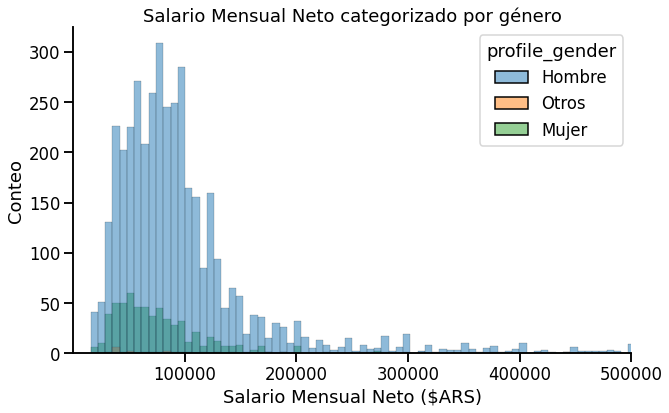

In [8]:
fig, ax = plt.subplots(figsize=(10,6))
seaborn.color_palette("Set2")
seaborn.despine()
seaborn.histplot(df_filtered, x="salary_monthly_NETO", ax = ax, hue="profile_gender", fill=True).set(title='Salario Mensual Neto \
categorizado por género',  xlabel='Salario Mensual Neto ($ARS)', ylabel='Conteo')
ax.set_xlim(1, 500000); # Se restringe la visualización al máximo de $500000.


Del anterior se puede inferir que la clase dominante es el género Hombre. Para representar y destacar a las otras clases se agruparán aquellos registros correspondientes Mujer y Otros.

1 d) Conformación de los grupos para su estudio: se segmento el conjunto de datos y se construyeron dos poblaciones de estudio
GrupoA = salario mensual Neto del grupo de Hombres
GrupoB = salario mensual Neto para el complemento de la población muestreada (No Hombres)

In [9]:
# Definición de filtro para genero = "Hombre"
is_man = df_filtered.profile_gender == 'Hombre'

# Definición de grupo A y B
groupA = df_filtered[is_man]
groupB = df_filtered[~is_man]

# Conteo de puntos muestrales que componen cada grupo
nA = len(groupA)
nB = len(groupB)
print(f'----- ------ ----- ------ ----- ------ ')
print(f'El grupo de encuestados cuyo género:')
print(f'  - Grupo A - Es "Hombre" se compone de {nA} muestras.')
print(f'  - Grupo B - NO es "Hombre" se compone de {nB} muestras.')
print(f'----- ------ ----- ------ ----- ------ ')

----- ------ ----- ------ ----- ------ 
El grupo de encuestados cuyo género:
  - Grupo A - Es "Hombre" se compone de 4002 muestras.
  - Grupo B - NO es "Hombre" se compone de 627 muestras.
----- ------ ----- ------ ----- ------ 


### 1 e) Histogramas de frecuencias Grupo A - Grupo B: 

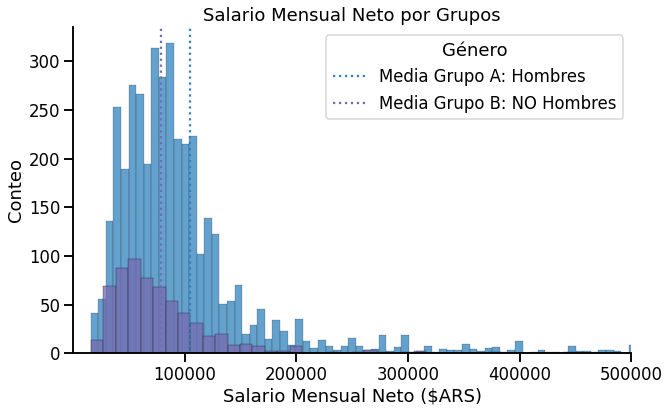

In [10]:
fig, ax = plt.subplots(figsize=(10,6))
seaborn.despine()
seaborn.histplot(groupA, x="salary_monthly_NETO", color= seaborn.color_palette("tab20c")[0] ,ax = ax,fill=True)
plt.axvline(groupA['salary_monthly_NETO'].mean(), color= seaborn.color_palette("tab20c")[0] ,linestyle='dotted')
seaborn.histplot(groupB, x="salary_monthly_NETO", color= seaborn.color_palette("tab20c\
")[12], ax = ax, fill=True).set(title='Salario Mensual Neto \
por Grupos',  xlabel='Salario Mensual Neto ($ARS)', ylabel='Conteo')
plt.axvline(groupB['salary_monthly_NETO'].mean(), color= seaborn.color_palette("tab20c")[12] ,linestyle='dotted')
ax.set_xlim(1, 500000) # Se restringe la visualización al máximo de $500000.
plt.legend(labels=["Media Grupo A: Hombres","Media Grupo B: NO Hombres"], title = "Género");



### 1 f) Estimación puntual de la diferencia entre las medias poblacionales:

In [11]:
mean_diff = groupA["salary_monthly_NETO"].mean()-groupB["salary_monthly_NETO"].mean()
print('----- ------ ----- ------ ----- ------ ----- ------ ----- ------ ----- ------')
print("La estimación puntual del parámetro diferencia de medias del \
salario neto mensual \n entre la población cuyo género es Hombre y la agrupación \
de Otros géneros (No Hombres) \n presentes  en el conjunto es de: " + f"${round(mean_diff,2)} (ARS)")

print('----- ------ ----- ------ ----- ------ ----- ------ ----- ------ ----- ------ ')


----- ------ ----- ------ ----- ------ ----- ------ ----- ------ ----- ------
La estimación puntual del parámetro diferencia de medias del salario neto mensual 
 entre la población cuyo género es Hombre y la agrupación de Otros géneros (No Hombres) 
 presentes  en el conjunto es de: $25811.13 (ARS)
----- ------ ----- ------ ----- ------ ----- ------ ----- ------ ----- ------ 


### 1 g) Estimación por intervalo de confianza a partir de la diferencia entre las medias poblacionales:


**Estadístico (Pivote)**
  
$\hspace{2cm} T=\frac{(\bar{X}-\bar{Y})-(μ_A- μ_B)}{S . \sqrt{\frac{n_1+n_2}{(n_1.n_2)}}} \hspace{2cm} S = \sqrt{\frac{\sum_{i=1}^{n_1}(X_i-\bar{X})^2+ \sum_{i=1}^{n_2}(Y_i-\bar{Y})^2}{n_1+n_2-2}} \\ \\ $

**Distribución del estadístico**

$ \hspace{2cm} T\sim t_{n_1+n_2-2}$

In [12]:
# Importante, debemos instalar esta versión específica de scipy para poder
# aplicar el parámetro "alternative" en la funcion ttest_ind

%pip install scipy==1.6.0

     |████████████████████████████████| 27.4 MB 9.7 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [13]:
# Importante, debemos instalar esta versión específica de scipy para poder
# aplicar el parámetro "alternative" en la funcion ttest_ind

!pip install scipy==1.6.0
from scipy.stats import ttest_ind                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
from scipy.stats import t

# Probabilidad de error - (Riesgo medible):
alpha = 0.05

# dof - (Degrees of freedom): 
dof = nA + nB - 2

# Desvio estándar de cada grupo
stdA = groupA['salary_monthly_NETO'].std()
stdB = groupB['salary_monthly_NETO'].std()
print('\n')
print("------ ----- ----- ----- ------ ----- ----- ----------- ----- ----- ----- ")
print("Dada la muestra bajo estudio, el desvío estándar del salario mensual \
neto para el grupo cuyo género es Hombre es:" +f' ${round(stdA,2)} ARS.')
print(f"Mientras que la desviación estándar del salario mensual del grupo cuyo género NO es Hombre es: ${round(stdB,2)} ARS.")
print("------ ----- ----- ----- ------ ----- ----- ----------- ----- ----- -----") 
    




------ ----- ----- ----- ------ ----- ----- ----------- ----- ----- ----- 
Dada la muestra bajo estudio, el desvío estándar del salario mensual neto para el grupo cuyo género es Hombre es: $102697.04 ARS.
Mientras que la desviación estándar del salario mensual del grupo cuyo género NO es Hombre es: $54323.62 ARS.
------ ----- ----- ----- ------ ----- ----- ----------- ----- ----- -----


**Soporte de cálculo para el estadístico:**

\begin{equation} 
s^2 = \frac{\sum_{i=1}^{N_1}(x_{i} - \bar{x})^{2} + \sum_{i=1}^{N_2}(y_{i} - \bar{y})^{2}}{{N_1} + {N_2} - 2}
\end{equation}

Partiendo de las definiciones de la varianza y el desvío... 

**Varianza:**

$$s^{2} = \frac{SS}{N - 1} = \frac{\sum (x_{i} - \bar{x})^{2}}{N - 1}$$

**Desvío Estándar:**

$$s = \sqrt{s^{2}} = \sqrt{\frac{SS}{N - 1}} = \sqrt{\frac{\sum (x_{i} - \bar{x})^{2}}{N - 1}}$$

$$\therefore  \sum_{i=1}^{N}(x_{i}-\bar{x})^2 = (N-1)* s^{2}
\sum (x_{i} - \bar{x})^{2}$$



$$\hspace{2cm}S^2 = \frac{\sum_{i=1}^{N_1}(x_i-\bar{x})^2+ \sum_{i=1}^{N_2}(y_i-\bar{y})^2}{N_1+N_2-2}$$


$$\hspace{2cm}S = \sqrt{\frac{\sum_{i=1}^{N_1}(x_i-\bar{x})^{2}+ \sum_{i=1}^{N_2}(y_i-\bar{y})^{2}}{{N_1} + {N_2} - 2}}$$





#### * Recordando que:
* Dada la muestra bajo estudio, el desvío estándar del salario mensual neto para el grupo cuyo género es Hombre es: \$102697.04 ARS.
Mientras que la desviación estándar del salario mensual del grupo cuyo género NO es Hombre es: \$54323.62 ARS.

* El grupo de encuestados cuyo género:
  - Grupo A - Es "Hombre" se compone de 4002 muestras.
  - Grupo B - NO es "Hombre" se compone de 627 muestras.


* dof = 4627

#### * Partiendo de las anteriores, calculamos la siguiente expresión:


In [14]:
std_AB = numpy.sqrt(((nA - 1)*(stdA)**2 + (nB - 1)*(stdB)**2) / dof)

A si mismo calculamos el Intervalo de confianza, que se define como:
$$\mathrm{CI} = \bar{X} \pm (t_{n - 1} \times \sigma_{\bar{X}})$$

In [15]:
# Percent point function: ppf(q, df, loc=0, scale=1)

# Calcula la función de distribución acumulada "inversa". Dada un distribución 
# de densidad de probabilidad (t, norm, etc ) determina el valor de la variable 
# que acumula una probabilidad específica.

# En otras palabras sea "q" una probabilidad dada, la función 
# devuelve x / P{T <= x} = q 
#   Donde: q es la probabilidad de obtener resultados <=x (distribución T).
# 
# Argumentos opcionales: 
#   loc (media) Por defecto 0
#   scale (desvío standar)(Por defecto 1).

t_val = t.ppf((1-alpha/2), dof)



In [16]:

# MoE: Margin of error
MoE = t_val * std_AB * numpy.sqrt(1/nA + 1/nB) 
li = mean_diff - MoE
ls = mean_diff + MoE
print(f'La diferencia entre las medias poblacionales de los grupos A y B es de {mean_diff:3.2f}') 
print(f'con el siguiente intervalo de confianza al {100-alpha*100}%: [{li:3.2f} - {ls:3.2f}]')

La diferencia entre las medias poblacionales de los grupos A y B es de 25811.13
con el siguiente intervalo de confianza al 95.0%: [17595.71 - 34026.55]


### En conclusión:

* La diferencia entre los grupos es de \$25811.13 ARS, comprendido en el intervalo de confianza al 95.0%: [17595.71 - 34026.55]. 

* A su vez podemos decir que si se realizará un test de hipótesis con $α = 0.05$, cualquier resultado que se encuentre dentro de este intervalo nos indica que no se podrá rechazar a la hipótesis nula ($H_0$), es decir **_que dice que no hay diferencia entre las medias_**. Por otro lado, se podría considerar el caso de obtener un resultado que se encuentre por fuera del intervalo calculado; en ese caso dado que asumimos que el supuesto es **_verdadero_**, si podría rechazarse $H_0$.

## Ejercicio 2: Test de hipótesis



### 2.1 Formalización

Describir formalmente los distintos compenentes de un test de hipótesis para comprobar si la distribución de los salarios es distinta entre los grupos A y B.

**Hipótesis Nula:**
##### Dada la población de programadores argentinos, la diferencia entre la media del _salario Neto_ para "_Hombres_" y la correspondiente media del salario Neto para _"otros géneros_" es cero.

$$\\ \hspace{2cm}H_0:μ_A- μ_B=0\hspace{2cm}μ_A= μ_B \\ $$

**Hipótesis Alternativa:**

$$\\ \hspace{2cm}H_1:μ_A- μ_B\neq 0\hspace{2cm}μ_A \neq μ_B \\ $$

$$\\ \hspace{2cm}H_1:μ_A- μ_B\neq 0\hspace{2cm}μ_A \neq μ_B \\ $$


  **Definimos el nivel de significancia** $\alpha=0.05$

  **Estadístico (Pivote)**
  
$\hspace{2cm} T=\frac{(\bar{X}-\bar{Y})-(μ_A- μ_B)}{S\sqrt{\frac{n_1+n_2}{(n_1.n_2)}}} \hspace{2cm}S = \sqrt{\frac{\sum_{i=1}^{n_1}(X_i-\bar{X})^2+ \sum_{i=1}^{n_2}(Y_i-\bar{Y})^2}{n_1+n_2-2}} \\ \\ $

  **Distribución del estadístico**

$ \hspace{2cm} T\sim t_{n_1+n_2-2}$

**Supuestos:** Ambas poblaciones poseen distribuciones normales y comparten la misma varianza. Las muestras tomadas de cada población son aleatorias e independientes.


### 2.2 P-valor

1. Calcule el p-valor y decida si rechazar o no la hipótesis nula.
2. Interprete el resultado.
3. Los dos grupos de nuestra muestra tienen tamaños muy distintos. ¿Esto afecta al tests?

Links útiles:
* [Test de hipótesis usando scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html)
* [Test de Welch](http://daniellakens.blogspot.com/2015/01/always-use-welchs-t-test-instead-of.html)

  2.2.1 Calculo del p-valor.


  Utilizamos la funcion ***_ttest_ind_*** del modulo scipy.stats. Descripción:

- Recibe como parametros de entradas las dos muestras a evaluar

- Devuelve el calculo del estadistico y el p-valor para el test planteado

- El parametro **equal_varbool**, (_True_ por defecto) aplica el test T de Student asumiendo que ambas varianzas poblacionales son iguales.
- Si por el contrario es configurado en _False_ aplica el **_Test de Welch_** (varianzas poblacionales distintas)

- El parametro opcional **alternative** {‘two-sided’, ‘less’, ‘greater’}, 
modela el "tipo de cola" a considerar para el test (psipy versión 1.6.0). 
En nuestro caso es dos colas dado que la hipotesis nula plantea una igualdad de medias. No hay relacion de orden que derive en uno u otro lado de la distribucion del estadistico. 

Configurando la función de acuerdo a lo expuesto previamente obtenemos:

In [17]:
# !pip install --upgrade scipy
test_res = ttest_ind(groupA.salary_monthly_NETO,groupB.salary_monthly_NETO, equal_var=True )  #alternative='two-sided'
print(test_res)
print(f'p-valor obtenido: {test_res[1]:1.15f}')


Ttest_indResult(statistic=6.15940871483383, pvalue=7.920790970055273e-10)
p-valor obtenido: 0.000000000792079


### En conclusión:
* Dado que el **_p-valor_ del test** de diferencia de medias es menor que $α$, se rechaza la $H_0$. Existe evidencia significativa para rechazar que las medias sean iguales.


### [Opcional] 2.3 Potencia del test

Nuestra muestra, ¿era lo suficientemente grande para detectar si existe o no una diferencia entre los grupos?

1. Utilice la función `tt_ind_solve_power` para calcular el tamaño necesario de la muestra para un poder estadístico de 0.8, 0.9 y 0.95, asumiendo una significancia estadística de 0.05.
2. ¿Cómo intepretan el poder estadístico de un test? Dado su conocimiento de dominio sobre los datos, ¿les parece que esta muestra es lo suficientemente grande para ser representativo de la tendencia general? ¿y para utilizarlo en un juicio penal contra una empresa XX por una causa de discriminación?

[Documentación](https://www.statsmodels.org/stable/generated/statsmodels.stats.power.tt_ind_solve_power.html)

NOTA: este análisis debería hacerse ANTES de recolectar los datos.

### Resolución del ejercicio opcional

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.power import tt_ind_solve_power

#Lista con las potencia estadisticas a utilizar para calcular el tamaño de muestra asociado
power2evaluate=[0.8, 0.9, 0.95]

#Labels auxiliares
labels=["0.8", "0.9", "0.95"]

#Lista donde localizaremos el tamaño de muestra calculado para cada potencia estadistica
the_sizes=[]

#Parametros queridos por la funcion:
effect_size = (groupA.salary_monthly_NETO.mean() - groupB.salary_monthly_NETO.mean()) / groupB.salary_monthly_NETO.std()
alpha = 0.05
ratio = len(groupB) / len(groupA)

#Calculo de la cantidad de muestras segun la potencia estadistica propuesta.
#Los resultados se guardan en la lista "the_sizes"
for one_power_test in power2evaluate:
  the_sizes.append(int(tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=one_power_test, ratio=ratio)))

#Armado de un DataFrame con la inforación de interes para su graficación
d = {'label':labels,'power': power2evaluate, 'sizeB': the_sizes}
df= pd.DataFrame(d)
df["sizeA"]= df["sizeB"]/ratio
df= df.astype({"sizeA":int})

print("------ ----- ----- ----- ------ ----- ----- ----------- ----- ----- -----") 

for i in df.index: 
     print("Para una Potencia estadistica de "+ df["label"][i] + \
           " el tamaño calculado para la muestra A es "+ str(df["sizeA"][i]) + \
           " y para la muestra B es " +str(df["sizeB"][i]))
print("------ ----- ----- ----- ------ ----- ----- ----------- ----- ----- -----") 
print(f"En nuestro experimento el tamaño de muestra para el grupo A fue de {len(groupA)}")
print(f"y para el grupo B fue de {len(groupB)}")
print("------ ----- ----- ----- ------ ----- ----- ----------- ----- ----- -----") 


------ ----- ----- ----- ------ ----- ----- ----------- ----- ----- -----
Para una Potencia estadistica de 0.8 el tamaño calculado para la muestra A es 1646 y para la muestra B es 258
Para una Potencia estadistica de 0.9 el tamaño calculado para la muestra A es 2202 y para la muestra B es 345
Para una Potencia estadistica de 0.95 el tamaño calculado para la muestra A es 2719 y para la muestra B es 426
------ ----- ----- ----- ------ ----- ----- ----------- ----- ----- -----
En nuestro experimento el tamaño de muestra para el grupo A fue de 4002
y para el grupo B fue de 627
------ ----- ----- ----- ------ ----- ----- ----------- ----- ----- -----


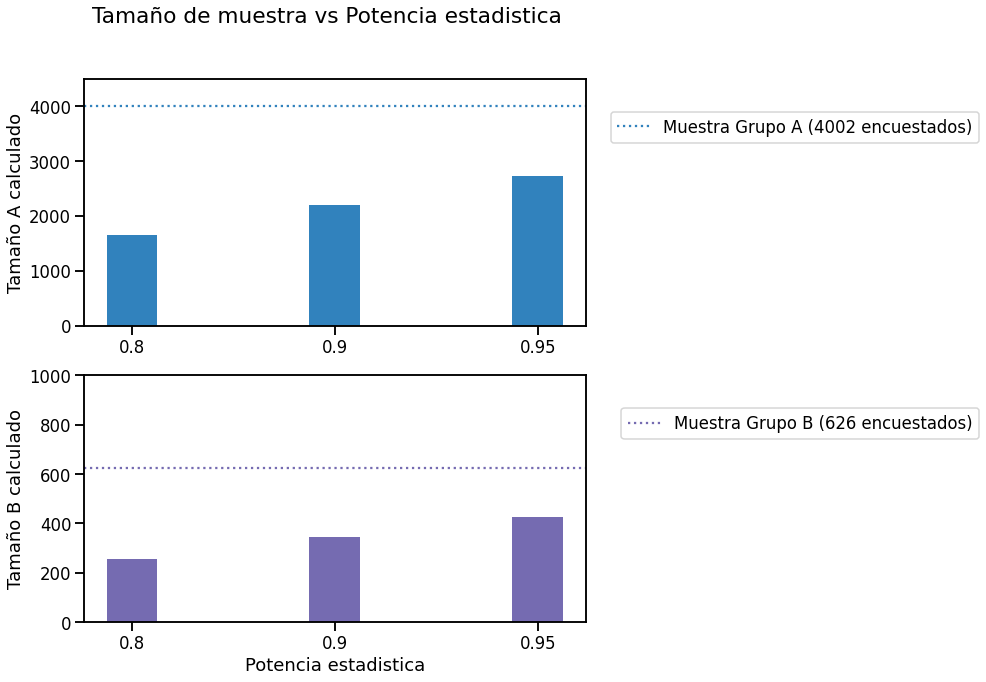

In [38]:
# Elavoración del gráfico
fig, axs = plt.subplots(2,figsize=(9,10))
fig.suptitle("Tamaño de muestra vs Potencia estadistica")

axs[0].bar(df["label"],df["sizeA"], 0.25, label="Hombres", color= seaborn.color_palette("tab20c")[0])
plt.gcf().get_axes()[0].set_ylim(0,4500)
axs[0].set_ylabel("Tamaño A calculado")

axs[0].axhline(y=4002, xmin=0, xmax=1, color= seaborn.color_palette("tab20c")[0], linestyle='dotted')
axs[0].legend(bbox_to_anchor=(1.0, 1.0, 0.8,-0.1), loc='upper right', labels=["Muestra Grupo A (4002 encuestados)"])
plt.gcf().get_axes()[1].set_ylim(0,1000)
axs[1].bar(df["label"],df["sizeB"],0.25 , label="No Hombres", color= seaborn.color_palette("tab20c")[12])
axs[1].axhline(y=626, xmin=0, xmax=1, color= seaborn.color_palette("tab20c")[12], linestyle='dotted')
axs[1].set_ylabel("Tamaño B calculado")
axs[1].legend(bbox_to_anchor=(1.0, 1.0, 0.8, -0.1), loc='upper right',labels=["Muestra Grupo B (626 encuestados)"])
axs[1].set_xlabel("Potencia estadistica")

plt.show()

**Conclusiones y Respuestas**

## Ejercicio 3: Comunicación y visualización

**Consigna:** Seleccionen un resultado que les parezca relevante a partir de alguno de los ejercicios del entregable. Diseñe e implemente una comunicación en base a este mensaje, en un archivo PDF.

Elija las palabras y visualización más adecuada para que la comunicación sea entendible, efectiva y se dapte a UNA de las siguientes situaciones:

1. Una sección en un artículo de difusión a presentar como parte de una organización sin fines de lucro.
No más de 1 página A4 (o dos si los gráficos son muy grandes).
  1. Ejemplo: Alguna de las secciones [Los ecosistemas de emprendimiento de América Latina y el Caribe frente al COVID-19: Impactos, necesidades y recomendaciones](https://publications.iadb.org/es/los-ecosistemas-de-emprendimiento-de-america-latina-y-el-caribe-frente-al-covid-19-impactos-necesidades-y-recomendaciones), por ejemplo la sección *2.2. Reacciones de los emprendedores*.
  2. Ejemplo: Alguna de las secciones de [The state of gender pay gap in 2021](https://www.payscale.com/data/gender-pay-gap?tk=carousel-ps-rc-job)
  3. Puntos clave: 
    1. Simpleza de los gráficos.
    2. Comunicación en lenguaje simple a personas que no son necesariamente expertos de dominio.
    2. Selección de UNA oración sobre la que se hace énfasis.
    3. No es necesario que mencionen objetivos ni descripciones del conjunto de datos, se supone que eso ya estaría explicado en otras secciones del informe.

2. Una publicación científica o reporte técnico interno. No más de una página A4:
  2. Ejemplo: La sección de resultados de [IZA DP No. 12914: The Impact of a Minimum Wage Change on the Distribution of Wages and Household Income](https://www.iza.org/publications/dp/12914/the-impact-of-a-minimum-wage-change-on-the-distribution-of-wages-and-household-income).
  2. Ejemplo: Alguna de las secciones de [Temporary reduction in daily global CO2 emissions during the COVID-19 forced confinement](https://www.nature.com/articles/s41558-020-0797-x)
  3. Puntos clave:
    3. Nivel de detalle técnico requerido. Es necesario justificar la validez del análisis.
    4. La idea presentada puede ser más compleja. Pueden asumir que la audiencia tiene conocimiento técnico y va a analizar las visualizaciones en detalle. 
    5. Pueden presentar más en detalle las limitaciones del análisis (significancia estadística, etc.)
    2. No es necesario que mencionen objetivos ni descripciones del conjunto de datos, se supone que eso ya estaría explicado en otras secciones del informe.

3. Un tweet (o post de LinkedIn) para la cuenta de su empresa consultora que hace análisis de datos. El objetivo es promocionar un análisis de datos abiertos que van a incluir en su portfolio:
  1. Ejemplo: [Comparación vacunas covid](https://twitter.com/infobeautiful/status/1381577746527236098?s=20)
  2. Ejemplo: [Tweet del BID](https://twitter.com/el_BID/status/1388508583944507396?s=20). Lo valioso de este tweet es que usaron un único número para transmitir un mensaje. Puede ser algo así, o con un gráfico muy simple.
  3. Ejemplo: [Cambio climático](https://twitter.com/UNFCCC/status/1387732156190011394?s=20) Es un muy buen ejemplo, excepto que el gráfico no se lee nada y hay que entrar a la publicación original.
  3. Ejemplo: [¿Cuánto están los programadores en las empresas?](https://www.linkedin.com/posts/denis-rothman-0b034043_tech-career-work-activity-6793861923269054464-gS6y) (No verificamos la veracidad o seriedad de la fuente).
  4. Puntos clave:
    1. Su audiencia no va a mirar la visualización por más de unos segundos, y no tiene conocimiento técnico.
  3. Tienen que incluir además una *breve* descripción de cómo obtuvieron los datos que están presentando, que no entraría en el tweet.
